# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

('ZW', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(3936, 114)
Index(['CL_Open', 'CL_High', 'CL_Low', 'CL_Close', 'CL_Volume', 'CL_Spread',
       'DC_Open', 'DC_High', 'DC_Low', 'DC_Close',
       ...
       'ZS_Low', 'ZS_Close', 'ZS_Volume', 'ZS_Spread', 'ZW_Open', 'ZW_High',
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread'],
      dtype='object', length=114)


,CL_Open,CL_High,CL_Low,CL_Close,CL_Volume,CL_Spread,DC_Open,DC_High,DC_Low,DC_Close,...,ZS_Low,ZS_Close,ZS_Volume,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-20 22:16:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0
2024-03-20 22:31:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0


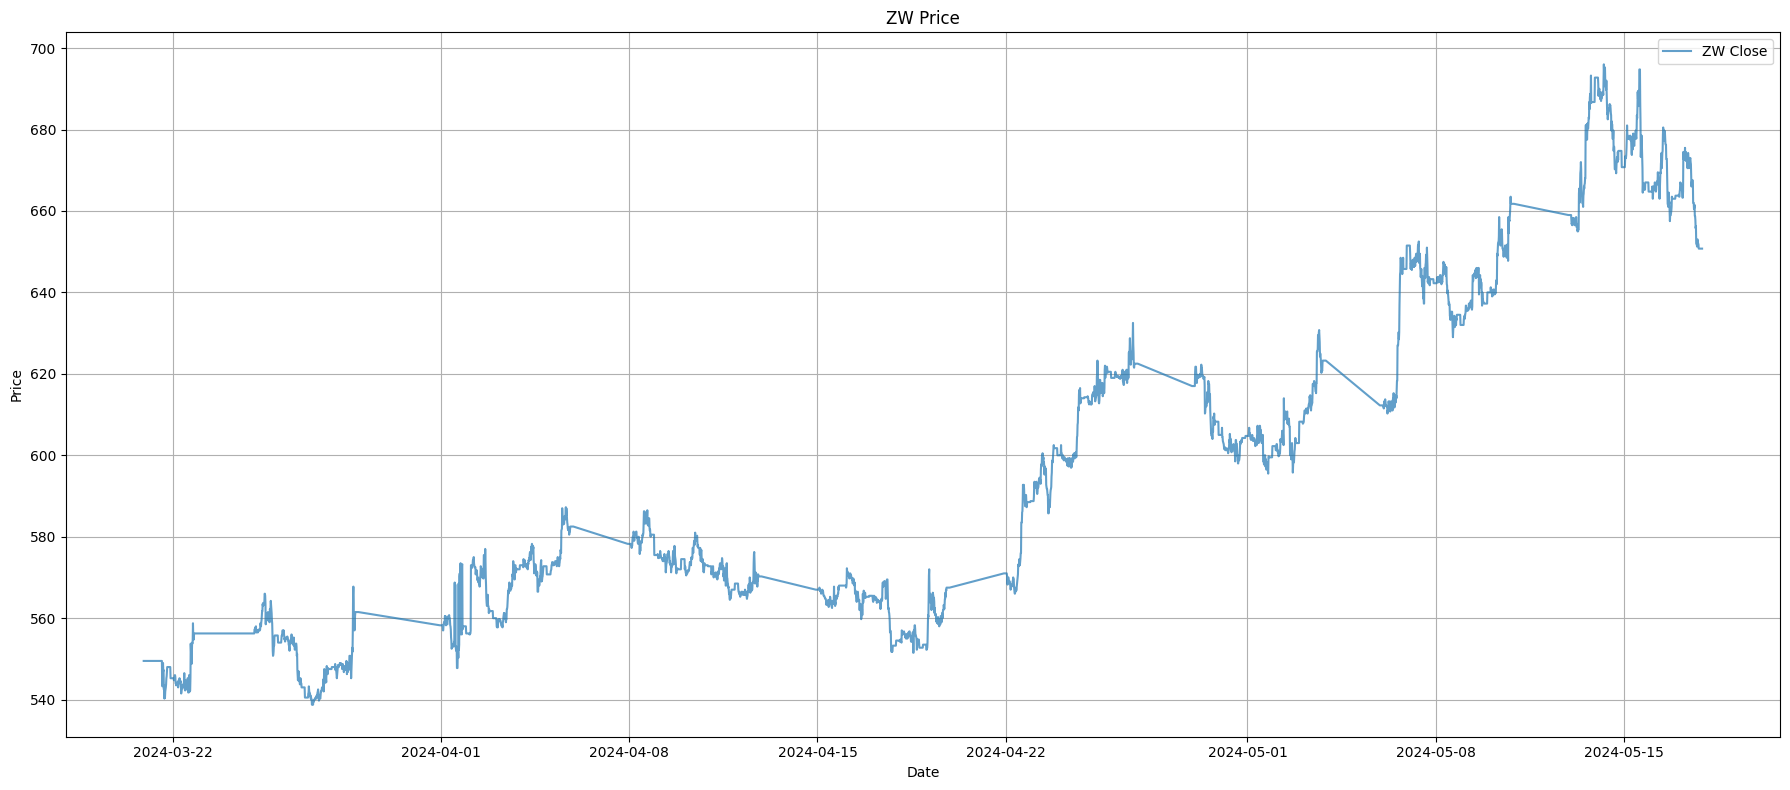

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]
target_fut_df

,ZW_Close
Date,
2024-03-20 22:16:00+00:00,549.50
2024-03-20 22:31:00+00:00,549.50
2024-03-20 22:46:00+00:00,549.50
2024-03-20 23:01:00+00:00,549.50
2024-03-20 23:16:00+00:00,549.50
...,...
2024-05-17 21:01:00+00:00,650.75
2024-05-17 21:16:00+00:00,650.75
2024-05-17 21:31:00+00:00,650.75


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 887
Hurst: 0.5200025427246997


In [11]:
import numpy as np
import pandas as pd

def kalman_filter_step(price, m_prev, R_prev, delta, ve, F, H):
    # Predict step
    m_pred = F @ m_prev
    R_pred = F @ R_prev @ F.T + delta

    # Update step
    K = R_pred @ H.T @ np.linalg.inv(H @ R_pred @ H.T + ve)
    m_curr = m_pred + K @ (price - H @ m_pred)
    R_curr = (np.eye(len(K)) - K @ H) @ R_pred

    return m_curr, R_curr

F = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
H = np.array([[1, 1, 1]])
delta = np.eye(3) * 0.001
ve = np.eye(1) * 0.1
n = 100
m = np.zeros((n, 3))
R = np.zeros((n, 3, 3))

window = abs(HALF_LIFE)
initial_prices = target_fut_df[f"{TARGET_FUT}_Close"].values[:window]
m[:window, 0] = initial_prices.mean()
m[:window, 1] = 0  # initial momentum component
m[:window, 2] = initial_prices.mean()
R[:window] = np.eye(3) * initial_prices.var()

# Apply Kalman filter
for t in range(window, n):
    m[t], R[t] = kalman_filter_step(target_fut_df[f"{TARGET_FUT}_Close"].values[t], m[t-1], R[t-1], delta, ve, F, H)

# Extract components
mean_reverting_component = m[:, 0]
momentum_component = m[:, 1]
random_walk_component = m[:, 2]
mean_reverting_component

array([554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69

In [12]:
momentum_component

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
random_walk_component

array([554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69306652,
       554.69306652, 554.69306652, 554.69306652, 554.69

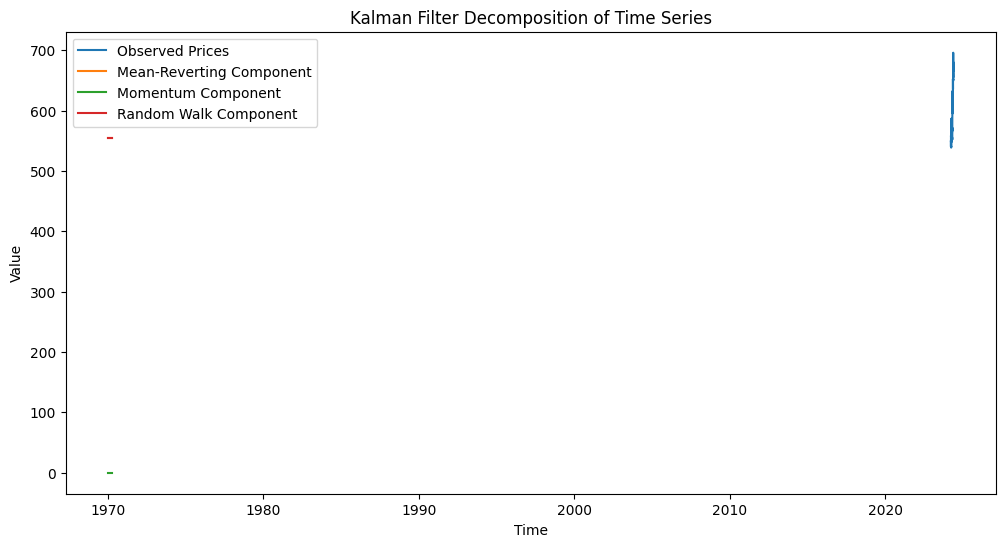

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target_fut_df.index, target_fut_df[f"{TARGET_FUT}_Close"], label='Observed Prices')
plt.plot(mean_reverting_component, label='Mean-Reverting Component')
plt.plot(momentum_component, label='Momentum Component')
plt.plot(random_walk_component, label='Random Walk Component')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Kalman Filter Decomposition of Time Series')
plt.show()
